In [0]:
import gensim
import keras
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, BatchNormalization, Activation, Bidirectional, Flatten
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers

import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
from keras.utils import plot_model 
from IPython.display import Image
import tensorflow as tf


np.random.seed(1003)

import os
os.chdir("/content/drive/My Drive/Datasets")

Using TensorFlow backend.


In [0]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
gensim.__version__

'3.6.0'

In [0]:
tf.__version__

'1.14.0-rc1'

In [0]:
keras.__version__

'2.2.4'

**Specify Hyperparameters**

In [0]:
# These are some hyperparameters that can be tuned
MAX_SENT_LEN = 23 # 90% of corpus
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 300
BATCH_SIZE = 32
N_EPOCHS = 10

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

# import os
# os.chdir("/content/drive/My Drive/Datasets")
# ! git clone https://github.com/tscpu172/Amazon-reviews-positive-or-negtive.git

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Load Data**

In [0]:
# Read the text files of positive and negative sentences
with open('/content/drive/My Drive/Datasets/Amazon-reviews-positive-or-negtive/DataSet/Neg/neg.txt', 'r', errors='ignore') as f:
    neg = f.readlines()
    
with open('/content/drive/My Drive/Datasets/Amazon-reviews-positive-or-negtive/DataSet/Pos/pos.txt', 'r', errors='ignore') as f:
    pos = f.readlines()

In [0]:
print('Number of negative sentences:', len(neg))
print('Number of positive sentences:', len(pos))

Number of negative sentences: 400000
Number of positive sentences: 400000


In [0]:
# Create a dataframe to store the sentence and polarity as 2 columns
df = pd.DataFrame(columns=['sentence', 'polarity'])
df['sentence'] = neg + pos
df['polarity'] = [0]*len(neg) + [1]*len(pos)
df = df.sample(frac=1, random_state=10) # Shuffle the rows
df.reset_index(inplace=True, drop=True)

In [0]:
df.head(10)

,sentence,polarity
0,That means the actual capacity is more like 20...,0
1,My only problem is that it is MADE IN CHINA.\n,0
2,The box that the item arrived in was kind of m...,0
3,It needed you to press fairly hard to register...,1
4,Now my makeup stays on longer and oil no longe...,0
5,This is the worst canned coffee I've ever had.\n,0
6,The secondary can be either incredibly telepat...,0
7,"I use these for cooking, eating, and especiall...",1
8,There's a gap between it and the ear when it's...,1
9,I guess they made their money and don't care.\n,0


In [0]:
# Pre-processing involves removal of puctuations and converting text to lower case
word_seq = [text_to_word_sequence(sent) for sent in df['sentence']]
print('90th Percentile Sentence Length:', np.percentile([len(seq) for seq in word_seq], 90))

90th Percentile Sentence Length: 23.0


In [0]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq])

print("Number of words in vocabulary:", len(tokenizer.word_index))

# tokenizer.word_index

Number of words in vocabulary: 93048


In [0]:
# Convert the sequence of words to sequnce of indices
X = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq])
X = pad_sequences(X, maxlen=MAX_SENT_LEN, padding='post', truncating='post')

y = keras.utils.to_categorical(df['polarity'])

In [0]:
y[:13]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [0]:
X[:3]

array([[  13,  738,    1, 1048, 1345,    8,   51,   27, 4320, 3452,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0],
       [  11,   61,  175,    8,   13,    4,    8,   93,   12,  979,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0],
       [   1,  249,   13,    1,  218,  480,   12,   20,  414,    9, 9061,
        5712,   13,    4,   20,  582,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)

In [0]:
# Split the dataset to train, validate, and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

In [0]:
X_train.shape

(648000, 23)

In [0]:
y_test.shape

(80000,)

In [0]:
%%time
# Load the word2vec embeddings 
import pickle
embeddings = gensim.models.Word2Vec.load('/content/drive/My Drive/Colab Notebooks/w2v_amazon_data.pkl')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


CPU times: user 309 ms, sys: 59 ms, total: 368 ms
Wall time: 2.38 s


In [0]:
print('Number of words in this pre-trained w2v model:', len(embeddings.wv.vocab))
print('Dimension of w2v:', embeddings.vector_size)

Number of words in this pre-trained w2v model: 15529
Dimension of w2v: 300


In [0]:
# Create an embedding matrix containing only the word's in our vocabulary
# If the word does not have a pre-trained embedding, then randomly initialize the embedding
embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(tokenizer.word_index)+1, EMBEDDING_DIM)) # +1 is because the matrix indices start with 0

for word, i in tokenizer.word_index.items(): # i=0 is the embedding for the zero padding
    try:
        embeddings_vector = embeddings[word]
    except KeyError:
        embeddings_vector = None
    if embeddings_vector is not None:
        embeddings_matrix[i] = embeddings_vector
        
del embeddings

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


**Keras Sequential API**

In [0]:
# Build a sequential model by stacking neural net units 
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, input_length=MAX_SENT_LEN,
                          output_dim=EMBEDDING_DIM, 
                          weights = [embeddings_matrix], trainable=False, name='word_embedding_layer'))



# model.add(keras.layers.GlobalAveragePooling1D())

model.add(Flatten())

model.add(Dense(128, activation='sigmoid', name='hidden_layer'))

# model.add(Dense(128, activation='tanh', kernel_regularizer=regularizers.l2(0.001), name='hidden_layer'))

model.add(Dropout(0.3, noise_shape=None, seed=None))

model.add(Dense(2, activation='softmax', name='output_layer'))

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, 23, 300)           27914700  
_________________________________________________________________
flatten_2 (Flatten)          (None, 6900)              0         
_________________________________________________________________
hidden_layer (Dense)         (None, 128)               883328    
_________________________________________________________________
output_layer (Dense)         (None, 2)                 258       
Total params: 28,798,286
Trainable params: 883,586
Non-trainable params: 27,914,700
_________________________________________________________________


In [0]:
adam=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [199]:
history = model.fit(X_train, y_train,
          batch_size=32,
          epochs=2,
          validation_data=(X_val, y_val))

Train on 648000 samples, validate on 72000 samples
Epoch 1/2
648000/648000 [==============================] - 82s 126us/step - loss: 0.4965 - acc: 0.7559 - val_loss: 0.4741 - val_acc: 0.7718
Epoch 2/2
648000/648000 [==============================] - 79s 122us/step - loss: 0.4618 - acc: 0.7793 - val_loss: 0.4631 - val_acc: 0.7772


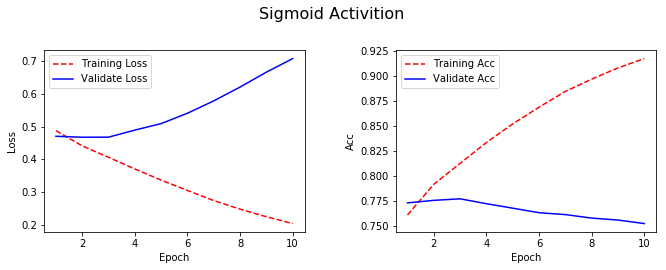

In [0]:
# Get training and test loss histories
training_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Loss', 'Validate Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')


# Get training and test acc histories
training_acc = history.history['acc']
val_acc = history.history['val_acc']

# Visualize loss history
plt.subplot(122)
plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, val_acc, 'b-')
plt.legend(['Training Acc', 'Validate Acc'])
plt.xlabel('Epoch')
plt.ylabel('Acc')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

my_suptitle = plt.suptitle('Sigmoid Activition', size=16, y=1.12)

plt.savefig("Sigmoid activition.tif", dpi=150, bbox_inches='tight',bbox_extra_artists=[my_suptitle])

plt.show();



In [0]:
print( os.getcwd() )
print( os.listdir() )

/content/drive/My Drive/Datasets
['Amazon-reviews-positive-or-negtive', 'sigmoid.tif']


In [0]:
from google.colab import files
files.download( "relu activition L2 norm Regularization.tif" )  

In [0]:
y_pred = model.predict_classes(X_test, batch_size=32)

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [0]:
100*(1-(y_test != y_pred).sum()/X_test.shape[0])


55.620000000000005

In [200]:
model.evaluate(X_test, y_test)[1]


80000/80000 [==============================] - 4s 50us/step


0.7764375